EXACT SOLUTION FOR MIDPOINT:
0.06160207590701994

U MATRICES
--------------------
[0.         0.06018519 0.        ]
[0.         0.03677263 0.06124282 0.05580999 0.        ]
[0.         0.019005   0.03695218 0.05183002 0.06151193 0.06372997
 0.05604062 0.03577941 0.        ]
[0.         0.00952592 0.01902992 0.02826975 0.03699726 0.04495783
 0.05188967 0.05752306 0.06157952 0.06377075 0.06379757 0.06134856
 0.05609858 0.04770704 0.03581584 0.02004703 0.        ]
[0.         0.00475243 0.00952917 0.01430045 0.01903615 0.02370583
 0.02827866 0.03272344 0.03700854 0.04110193 0.04497112 0.04858316
 0.05190459 0.05490145 0.05753921 0.05978278 0.06159644 0.06294384
 0.06378794 0.064091   0.06381449 0.06291909 0.06136461 0.05910996
 0.05611309 0.05233092 0.04771927 0.04223281 0.03582496 0.02844784
 0.02005212 0.01058698 0.        ]
[0.         0.00237154 0.00475285 0.00714023 0.00952999 0.01191837
 0.01430164 0.01667602 0.01903771 0.0213829  0.02370774 0.02600837
 0.0282809  0.03052141 0.0327

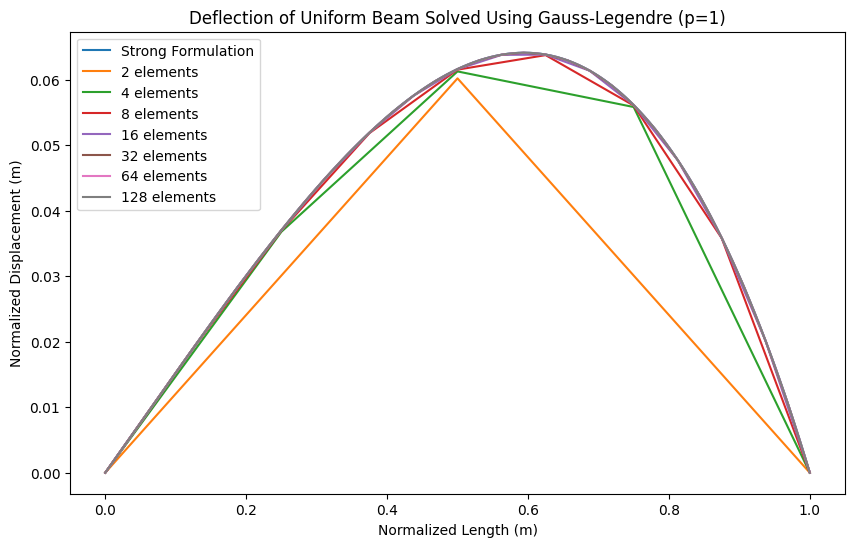

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


rho = 1
omega = 1
A0 = 1
A_L = (7/11) * A0
E = 1
L = 1

K_1 = (-(1/9) + (11/48) + (121/96) + (1331/384) * np.log((7/11))) / ((11/4) * np.log((7/11)))

K_2 = -3993/256

# strong formulation
xs = np.linspace(0, L, 250)
u = [-(1/9)*x**3 + (11/48)*x**2 + (121/96)*x + 1331/384*np.log(-4*x/11 + 1) + 3993/256 - K_1 * 11/4*np.log(1-4*x/11) + K_2 for x in xs]

plt.figure(figsize=(10,6))
plt.plot(xs, u, label='Strong Formulation')

def u(x):
  return -(1/9)*x**3 + (11/48)*x**2 + (121/96)*x + 1331/384*np.log(-4*x/11 + 1) + 3993/256 - K_1 * 11/4*np.log(1-4*x/11) + K_2

def normal(x):
  return -(x**2/2 - 4*x**3/33/L) + K_1

# weak formulation
def A(x):
  return A0 * (1 - 4*x/11/L)

def f(x):
  return rho * A(x) * omega * omega * x


# This function will be used to make the spatial transform necessary for G-L integration
# Let's assume that we can straight plug xi in for x and compensate in the dxi term

def psi_1(x_if, x_i0, x):
  return (x_if - x) / (x_if - x_i0)

def psi_2(x_if, x_i0, x):
  return (x - x_i0) / (x_if - x_i0)

def z_2_x(x_if, x_i0, z):
  return (x_if - x_i0) / 2 * z + (x_if + x_i0) / 2

def k_mn_i(x_if, x_i0, z, m, n):
  deriv_1 = 0
  deriv_2 = 0
  # handles first psi derivative
  if m == 1:
    deriv_1 = -1 / (x_if - x_i0)
  else:
    deriv_1 = 1 / (x_if - x_i0)

  # handles second psi derivative
  if n == 1:
    deriv_2 = -1 / (x_if - x_i0)
  else:
    deriv_2 = 1 / (x_if - x_i0)

  return E * A(z_2_x(x_if, x_i0, z)) * deriv_1 * deriv_2 * (x_if - x_i0) / 2

def f_m_i(x_if, x_i0, z, m):
  psi = 0

  # handles decision for psi
  if m == 1:
    psi = psi_1(x_if, x_i0, z_2_x(x_if, x_i0, z))
  else:
    psi = psi_2(x_if, x_i0, z_2_x(x_if, x_i0, z))

  return f(z_2_x(x_if, x_i0, z)) * psi * (x_if - x_i0) / 2


# creating the mesh
def fem_mesh(num):
  return np.linspace(0, 1, num+1)

# set up global assembly to interact with mesh function
# num is number of elements (intervals) to consider
def global_assembly(num, choice, choice2):
  mesh = fem_mesh(num)

  left_coefs = np.zeros((num-1, num-1))

  right_coefs = np.zeros((num-1, 1))

  # goes from 1 to n - 1 due to assuming that the ends have no deflection
  f11 = 0
  k_12_1 = 0
  k_11_1 = 0
  for i in range(0, num-1):
    x_iminus1 = mesh[i]
    x_i = mesh[i+1]
    x_iplus1 = mesh[i+2]

    if i == 0:
      f11 = (f_m_i(x_i, x_iminus1, -np.sqrt(3)/3, 1) + f_m_i(x_i, x_iminus1, np.sqrt(3)/3, 1))
      k_12_1 = (k_mn_i(x_i, x_iminus1, -np.sqrt(3)/3, 2, 1) + k_mn_i(x_i, x_iminus1, np.sqrt(3)/3, 2, 1))

    for j in range(0, num-1):
      if i == j:
        left_coefs[i][j] = (k_mn_i(x_i, x_iminus1, -np.sqrt(3)/3, 2, 2) + k_mn_i(x_i, x_iminus1, np.sqrt(3)/3, 2, 2)) + (k_mn_i(x_iplus1, x_i, -np.sqrt(3)/3, 2, 2) + k_mn_i(x_iplus1, x_i, np.sqrt(3)/3, 1, 1))

      elif j == i + 1:
        left_coefs[i][j] = (k_mn_i(x_iplus1, x_i, -np.sqrt(3)/3, 1, 2) + k_mn_i(x_iplus1, x_i, np.sqrt(3)/3, 1, 2))

      elif j == i - 1:
        left_coefs[i][j] = (k_mn_i(x_i, x_iminus1, -np.sqrt(3)/3, 2, 1) + k_mn_i(x_i, x_iminus1, np.sqrt(3)/3, 2, 1))

    right_coefs[i][0] = (f_m_i(x_i, x_iminus1, -np.sqrt(3)/3, 2) + f_m_i(x_i, x_iminus1, np.sqrt(3)/3, 2)) + (f_m_i(x_iplus1, x_i, -np.sqrt(3)/3, 1) + f_m_i(x_iplus1, x_i, np.sqrt(3)/3, 1))

  U = np.linalg.inv(left_coefs) @ right_coefs
  pt1 = np.array([[0]])
  ptlast = np.array([[0]])
  tot_U = np.vstack((pt1, np.vstack((U, ptlast))))

  if choice:
    print(tot_U.T[0])

  if choice2:
    return f11 - k_12_1 * tot_U.T[0][1]

  return mesh, tot_U.T[0]

print('EXACT SOLUTION FOR MIDPOINT:')
print(u(0.5))
print()

print('U MATRICES')
print('--------------------')
plt.xlabel('Normalized Length (m)')
plt.ylabel('Normalized Displacement (m)')
plt.title('Deflection of Uniform Beam Solved Using Gauss-Legendre (p=1)')

midpoints = []
for n in range(1, 8):
  mesh, data = global_assembly(2**n, True, False)
  plt.plot(mesh, data, label=str(2**n)+' elements')

  num = int((2**n + 1) / 2 - 0.5)
  midpoints.append(data[num])

plt.legend(loc='upper left')
plt.show()

Rate of Midpoint Convergence:
-------------------------------------------

Rate of convergence from 2 to 4 is: 1.9796290170999897
Rate of convergence from 4 to 8 is: 1.9946861896940122
Rate of convergence from 8 to 16 is: 1.9986563669393365
Rate of convergence from 16 to 32 is: 1.9996631182320777
Rate of convergence from 32 to 64 is: 1.9999157176965927
Rate of convergence from 64 to 128 is: 1.999978927512942


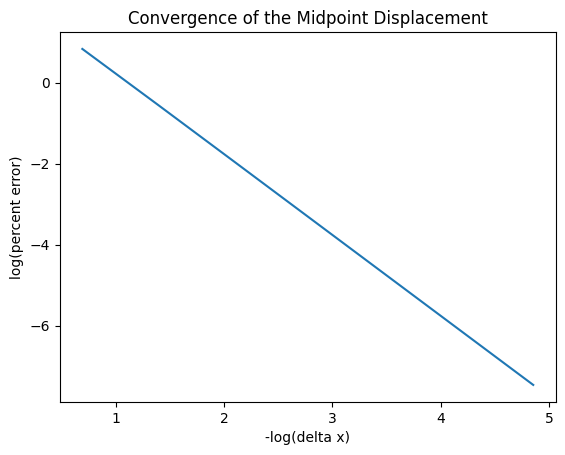

In [ ]:
# Rate of Midpoint Displacement Convergence
exact_midpoint = u(0.5)
midpoint_errors = [np.log(np.abs(exact_midpoint - x) / np.abs(exact_midpoint) * 100) for x in midpoints]
midpoint_abs_errors = [np.abs(exact_midpoint - x) for x in midpoints]
delta_xs = [np.log((0.5)**i)*-1 for i in range(1, 8)]

plt.title('Convergence of the Midpoint Displacement')
plt.xlabel('-log(delta x)')
plt.ylabel('log(percent error)')
plt.plot(delta_xs, midpoint_errors)



print('Rate of Midpoint Convergence:')
print('-------------------------------------------')
print()
# Considering the later values, particularly 2^4 subintervals and on
for i in range(0, len(midpoint_abs_errors) - 1):
  print('Rate of convergence from', 2**(i+1), 'to', 2**(i+2), 'is:', np.log2(midpoint_abs_errors[i]/midpoint_abs_errors[i+1]))

In [ ]:
# Convergence Calculations / Graph

# Exact root reaction
print('Exact Method of Root Reaction')
print('-----------------------------------------------')
print()
print(normal(0))
root_exact = normal(0)

print()


# we choose to analyze 4 to 8, 8 to 16, and 16 to 32

# root reaction by direct differentiation at 2 to 128
print('Direct Differentiation Method of Root Reaction:')
print('-----------------------------------------------')
print()
root_dd_lst = []
for i in range(1, 13):
  mesh, data = global_assembly(2**i, False, False)
  root_dd = E * A0 * data[1] / (mesh[1] - mesh[0])
  root_dd_lst.append(root_dd)
  print(2**i, 'elements give', root_dd)

print()


# root reaction by weak formulation at 2 to 1024
print('Weak Formulation Method of Root Reaction:')
print('-----------------------------------------')
print()
root_weak_lst = []
for j in range(1, 13):
  # HAHAHAHAHAHAHAHAHAHAHA IT WAS A VARIABLE OF ITERATION ERROROR HAHAHAHAHAHAHAHAHAAH I LOVE CODING!!!!!!!!!!!!!!!!!
  root_weak = global_assembly(2**j, False, True)
  root_weak_lst.append(root_weak)
  print(2**j, 'elements give', root_weak)

Exact Method of Root Reaction
-----------------------------------------------

0.15139205516732435

Direct Differentiation Method of Root Reaction:
-----------------------------------------------

2 elements give 0.12037037037037035
4 elements give 0.1470905172413793
8 elements give 0.15203997927873117
16 elements give 0.15241466622725222
32 elements give 0.15207785986459765
64 elements give 0.1517785597831047
128 elements give 0.15159620509489338
256 elements give 0.15149685415950526
512 elements give 0.15144513562291925
1024 elements give 0.15141876562897996
2048 elements give 0.15140545295582544
4096 elements give 0.15139876470105923

Weak Formulation Method of Root Reaction:
-----------------------------------------

2 elements give 0.1473063973063973
4 elements give 0.15034776645768025
8 elements give 0.1511295062648206
16 elements give 0.15132632484966982
32 elements give 0.15137561675693895
64 elements give 0.1513879452000916
128 elements give 0.1513910276527235
256 elements giv

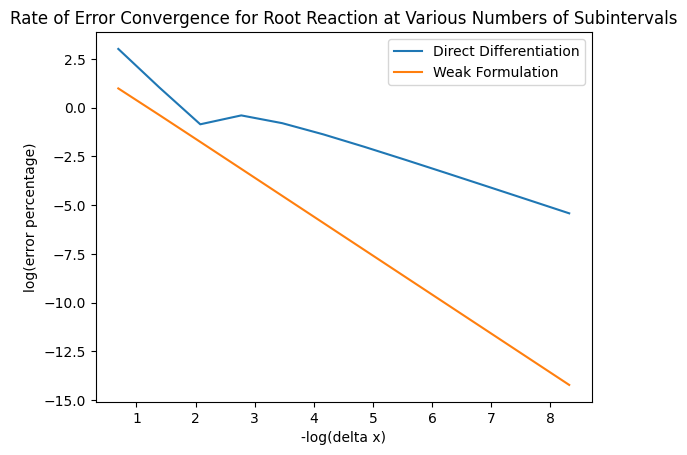

In [ ]:
root_dd_errors = [np.log(np.abs((root_exact - x)) / np.abs(root_exact) * 100) for x in root_dd_lst]
root_weak_errors = [np.log(np.abs((root_exact - x)) / np.abs(root_exact) * 100) for x in root_weak_lst]
delta_xs = [np.log((0.5)**i)*-1 for i in range(1, 13)]

plt.plot(delta_xs, root_dd_errors, label='Direct Differentiation')
plt.plot(delta_xs, root_weak_errors, label='Weak Formulation')
plt.xlabel('-log(delta x)')
plt.ylabel('log(error percentage)')
plt.title('Rate of Error Convergence for Root Reaction at Various Numbers of Subintervals')
plt.legend(loc='upper right')
plt.show()

In [ ]:
# Actual calculation of the rates of convergence
# Direct Differentiation method

root_dd_absolute_errors = [np.abs(x - root_exact) for x in root_dd_lst]
root_weak_absolute_errors = [np.abs(x - root_exact) for x in root_weak_lst]


print('Direct Differentiation Rate of Convergence:')
print('-------------------------------------------')
print()
# Considering the later values, particularly 2^4 subintervals and on
for i in range(3, len(root_dd_absolute_errors) - 1):
  print('Rate of convergence from', 2**(i+1), 'to', 2**(i+2), 'is:', np.log2(root_dd_absolute_errors[i]/root_dd_absolute_errors[i+1]))

print()

print('Weak Formulation Rate of Convergence:')
print('-------------------------------------')
print()
# Considering the same values as in the DD method, 2^4 subintervals and on
for j in range(3, len(root_weak_absolute_errors) - 1):
  print('Rate of convergence from', 2**(j+1), 'to', 2**(j+2), 'is:', np.log2(root_weak_absolute_errors[j]/root_weak_absolute_errors[j+1]))

Direct Differentiation Rate of Convergence:
-------------------------------------------

Rate of convergence from 16 to 32 is: 0.5763878436652645
Rate of convergence from 32 to 64 is: 0.8273121422919221
Rate of convergence from 64 to 128 is: 0.920856587743021
Rate of convergence from 128 to 256 is: 0.9620042127094172
Rate of convergence from 256 to 512 is: 0.9813721843246603
Rate of convergence from 512 to 1024 is: 0.9907758422610388
Rate of convergence from 1024 to 2048 is: 0.995410028659617
Rate of convergence from 2048 to 4096 is: 0.9977104647127579

Weak Formulation Rate of Convergence:
-------------------------------------

Rate of convergence from 16 to 32 is: 1.9994881617990317
Rate of convergence from 32 to 64 is: 1.999871998383462
Rate of convergence from 64 to 128 is: 1.9999679973136955
Rate of convergence from 128 to 256 is: 1.9999920458165041
Rate of convergence from 256 to 512 is: 1.9999976041044585
Rate of convergence from 512 to 1024 is: 1.999995132774621
Rate of converg